<a href="https://colab.research.google.com/github/maelleal/TCC_Recomendacao_INE/blob/main/Modelos_classifica%C3%A7%C3%A3o_ponderada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn
from google.colab import drive
drive.mount('/content/drive')
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import TruncatedSVD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [2]:
dataset = pandas.read_excel('/content/drive/My Drive/TCC - Sistema recomendação INE/Tabela para modelo medias v2.xlsx')
dataset = dataset.replace(["#N/A"], 0)
#dataset = dataset.replace(to_replace=r'^INE', value='', regex=True)
# dataset_filtrado = dataset
dataset_filtrado = dataset.drop(columns=['ID_UFSC'])
dataset_filtrado = dataset_filtrado.replace(np.nan, 0)
# dataset_filtrado.round(3)
dataset_filtrado = dataset_filtrado.round(2)
dataset_filtrado.head()
dataset_filtrado.describe()

,MATRICULA,ORIENTADOR,COD_AREA,MEDIA_NOTA,Area1,Area2,Area3,Area4,Area5,Area6,Area7,Area8,Area9,Area10,Area11,Area12,Area13
count,3.140000e+02,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,1.174535e+07,14.789809,7.525478,8.815064,6.234713,5.374108,5.854268,5.832102,5.204045,5.665096,5.548376,5.831975,6.238153,5.625446,5.431561,4.511083,3.015924
std,2.225027e+06,9.086754,4.276504,1.751960,3.468189,3.176503,3.286562,3.287859,2.978466,3.307799,3.254366,3.355372,3.759515,3.236287,3.130265,3.554699,3.559685
min,6.132074e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.020061e+07,8.000000,3.000000,8.670000,7.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,0.000000,6.000000,6.032500,0.000000,0.000000
50%,1.210076e+07,13.000000,10.000000,9.170000,7.750000,6.840000,7.380000,7.000000,6.340000,6.500000,6.500000,7.250000,7.775000,7.170000,6.900000,6.790000,0.000000
75%,1.320065e+07,21.000000,12.000000,9.750000,8.250000,7.340000,7.920000,7.600000,7.000000,8.000000,7.460000,8.170000,9.130000,7.500000,7.250000,7.400000,6.597500
max,1.820042e+07,34.000000,13.000000,10.000000,9.750000,9.500000,10.000000,10.000000,10.000000,10.000000,10.000000,9.670000,10.000000,9.500000,8.930000,8.720000,8.840000


    COD_AREA  vote_count  avg_rating
0        0.0           7    8.712857
1        1.0           8    7.311250
2        3.0          82    8.732805
3        4.0          40    8.538500
4        5.0           4    9.512500
5        7.0          14    8.743571
6        8.0           1    9.500000
7       10.0          57    9.462982
8       11.0           1   10.000000
9       12.0          58    8.558966
10      13.0          42    8.929762
     COD_AREA  vote_count  weighted_rating  ORIENTADOR   COD_MAT
146      10.0          57         9.353822          16  INE5429 
162      10.0          57         9.353822          13  INE5680 
164      10.0          57         9.353822          13  INE5429 
165      10.0          57         9.353822          13  INE5680 
166      10.0          57         9.353822           4  INE5619 
..        ...         ...              ...         ...       ...
226      12.0          58         8.627102           3  INE5430 
225      12.0          58         8.

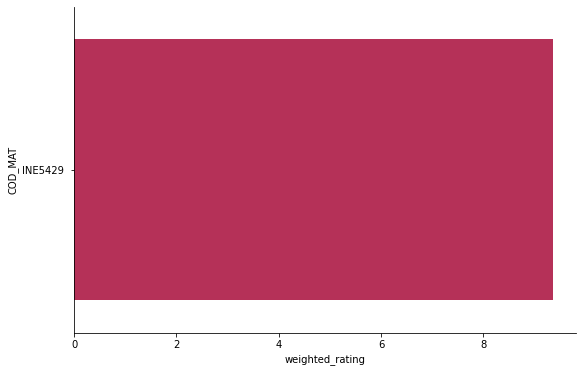

In [8]:
def weighted_rating(v,m,R,C):
    '''
    Calculate the weighted rating
    
    Args:
    v -> average rating for each item (float)
    m -> minimum votes required to be classified as popular (float)
    R -> average rating for the item (pd.Series)
    C -> average rating for the whole dataset (pd.Series)
    
    Returns:
    pd.Series
    '''
    return ( (v / (v + m)) * R) + ( (m / (v + m)) * C )

def assign_popular_based_score(rating_df, item_df, user_col, item_col, rating_col):
    '''
    Assigned popular based score based on the IMDB weighted average.
    
    Args:
    rating -> pd.DataFrame contains ['item_id', 'rating'] for each user.
    
    Returns
    popular_items -> pd.DataFrame contains item and IMDB weighted score.
    '''
    
    # pre processing
    vote_count = (
        rating_df
        .groupby(item_col,as_index=False)
        .agg( {user_col:'count', rating_col:'mean'} )
        )
    vote_count.columns = [item_col, 'vote_count', 'avg_rating']
    
    print(vote_count)

    # calcuate input parameters
    C = np.mean(vote_count['avg_rating'])
    m = np.percentile(vote_count['vote_count'], 50)
    vote_count = vote_count[vote_count['vote_count'] >= m]
    R = vote_count['avg_rating']
    v = vote_count['vote_count']
    vote_count['weighted_rating'] = weighted_rating(v,m,R,C)
    
    # post processing
    vote_count = vote_count.merge(item_df, on = [item_col], how = 'left')
    popular_items = vote_count.loc[:,[item_col, 'vote_count', 'weighted_rating', 'ORIENTADOR', 'COD_MAT']]
    
    return popular_items

# init constant
USER_COL = 'MATRICULA'
ITEM_COL = 'COD_AREA'
RATING_COL = 'MEDIA_NOTA'

# calcualte popularity based
pop_items = assign_popular_based_score(dataset_filtrado, dataset, USER_COL, ITEM_COL, RATING_COL)
pop_items = pop_items.sort_values('weighted_rating', ascending = False)

pop_items.describe()

# plot the popularity based on the weighted score
import seaborn as sns
fix, ax = plt.subplots(figsize=(9,6))
sns.barplot(data = pop_items.head(1),
            y = 'COD_MAT',
            x = 'weighted_rating',
            palette = 'rocket');
sns.despine();
print(pop_items)